In [1]:
import os
import sys
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from network_utils import MultiLayerCNN, np2torch, device, MultiLayerCNNPolicy
from environment import Environment
import matplotlib.pyplot as plt
import hiddenlayer as hl
from torchviz import make_dot


# ---------------------------------------------------------------------------- #
#                                     Input                                    #
# ---------------------------------------------------------------------------- #
# Can modify
DATADIR = input("Enter dataset directory: ")
if not os.path.exists(DATADIR):
    print("Directory doesn't exists!")
    sys.exit(1)
batch_size = 64
TRAINING_MODE = input("Enter training mode (pick, place, all): ").lower()

# ---------------------------------------------------------------------------- #
#                                  Environment                                 #
# ---------------------------------------------------------------------------- #

env_generator = Environment()
env = env_generator.create_env(fixed_placement=True)
action_dim = env.action_dim
with open(os.path.join(DATADIR, "obs_dims.json"), "r") as f:
    obs_dict = json.load(f)
    obs_dims = sum([v for k, v in obs_dict.items()])
    train_dims = sum([v for k, v in obs_dict.items() if k in [
        "robot0_joint_pos_cos",
        "robot0_joint_pos_sin",
        "robot0_joint_vel",
        "robot0_eef_pos",
        "robot0_eef_quat",
        "robot0_gripper_qpos",
        "robot0_gripper_qvel"
    ]])

with open(os.path.join(DATADIR, "img_dims.json"), "r") as f:
    img_dims = sum([v for k, v in json.load(f).items()])

# ---------------------------------------------------------------------------- #
#                                    Helper                                    #
# ---------------------------------------------------------------------------- #
def create_dataloader(obs, actions, batch_size: int):
    tensor_dataset = TensorDataset(np2torch(obs), np2torch(actions))
    dataloader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# ---------------------------------------------------------------------------- #
#                                    Network                                   #
# ---------------------------------------------------------------------------- #

network = MultiLayerCNN(
    obs_input_size=train_dims,
    img_input_height=int(np.sqrt(img_dims / 3)),
    img_input_width=int(np.sqrt(img_dims / 3)),
    output_size=action_dim
).to(device=device)
optimizer = torch.optim.Adam(network.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss()


# ---------------------------------------------------------------------------- #
#                                   Training                                   #
# ---------------------------------------------------------------------------- #

obs_filepaths = [
    os.path.join(DATADIR, filename)\
        for filename in os.listdir(DATADIR) if "observations" in filename
]

imgs_filepaths = [
    os.path.join(DATADIR, filename)\
        for filename in os.listdir(DATADIR) if "imgs" in filename
]

combined_filepaths = []
for filename in obs_filepaths:
    common_name = "_" + "_".join(filename.split("_")[-2:])
    img_filename = [img_file for img_file in imgs_filepaths if common_name in img_file][0]
    combined_filepaths.append((filename, img_filename))

# Change the epochs here
epochs = 10
file_no = 0
total_file = len(obs_filepaths) * epochs
print("...Start Training...")
for i in range(epochs):
    for filepath_obs, filepath_imgs in combined_filepaths:
        print()
        file_no += 1
        try:
            df_obs = pd.read_csv(filepath_obs)
            df_imgs = pd.read_csv(filepath_imgs)
            if TRAINING_MODE == "pick":
                df_obs = df_obs[df_obs["subtask_id"] <= 4]
                df_imgs = df_imgs[df_imgs["subtask_id"] <= 4]
            elif TRAINING_MODE == "place":
                df_obs = df_obs[df_obs["subtask_id"] > 4]
                df_imgs = df_imgs[df_imgs["subtask_id"] > 4]
        except:
            continue
        obs = df_obs.iloc[:, 0:train_dims]
        imgs = df_imgs.iloc[:, 0:img_dims]
        
        obs_imgs = pd.concat([obs, imgs], axis=1).values.astype(np.float32)
        actions = df_obs.iloc[:, obs_dims:(obs_dims+action_dim)].values.astype(np.float32)
        
        dataloader = create_dataloader(obs_imgs, actions, batch_size=batch_size)
        n_dataloader = len(dataloader)
        del obs, imgs, obs_imgs, actions, df_obs, df_imgs

        for batch, (X, y) in enumerate(dataloader):

            y_hat = network(X)
            loss = criterion(y_hat, y)
            break

        break


/Users/kelvinchristian/miniconda3/envs/cs234/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


...Start Training...












In [4]:
network = MultiLayerCNNPolicy(
    obs_input_size=train_dims,
    img_input_height=int(np.sqrt(img_dims / 3)),
    img_input_width=int(np.sqrt(img_dims / 3)),
    observation_space="ls"
)

In [ ]:
net = 

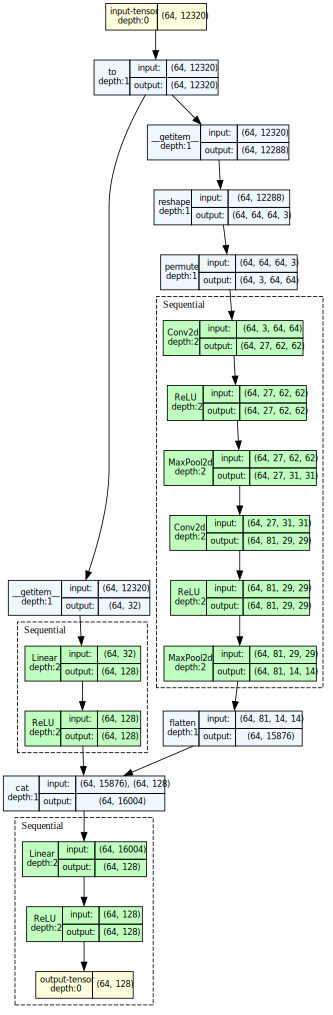

In [5]:
from torchview import draw_graph

model_graph = draw_graph(network, input_size=(64, 12320), expand_nested=True)
model_graph.visual_graph